# Cognition and computation
# Giulio Nebbiai


---

## Introduction to the project




The aim of this project is to analyze the efficiency of a Deep Belief Network and Feed-Forward Neural Network. It will also be investigated further to see how resilient they are to adversarial attacks and data noise.

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

We use some useful script from DBN and RBM. We are connecting from the remote serve for computing and downloading this data.

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as functional
import torchvision as tv
from torch.utils.data import random_split
from tqdm.notebook import tqdm
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
from DBN import DBN

# EMNIST dataset

Firstly, we import the data. We use "EMNIST" dataset taken from "https://github.com/aurelienduarte/emnist". Before to see how it is composed, we check if we have a cuda device.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


We consider the dataset with only letters; we have 26 classes, at each class corresponds a number from 1 to 25 that indicates the resulting letter of the alphabet, while to 26 corresponds NA values. We have 145,600 characters with a 28x28 pixel image format.

We split our dataset into training set and test set, obtaining 124800 images of letters in our training set and 20800 images in the test set.

In [ ]:
%%capture
emnist_train = tv.datasets.EMNIST('data/',
                                    split='letters',
                                    train =True,
                                    download=True,
                                    transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()])
                                      )

emnist_test = tv.datasets.EMNIST('data/',
                                    split='letters',
                                    train =False,
                                    download=True,
                                    transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()])
                                      )


We perform normalization by dividing each tensor by 255, so each pixel is scaled between 0 and 1.

In [ ]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

The number shown is the number: 7


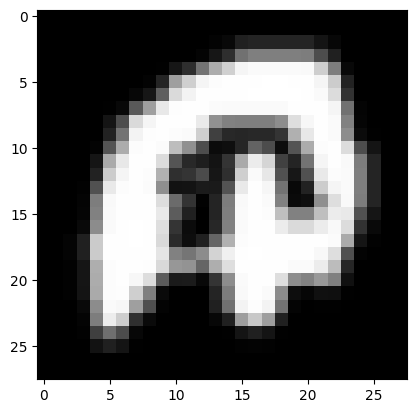

In [ ]:
idx = 1
img = emnist_train.data[idx]
print("The number shown is the number: {}".format(emnist_train.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

We subtract 1 to the targets; shifting down the targets by one avoids us to analyze the NA values.

In [ ]:
print((emnist_train.targets))
print(max(emnist_train.targets))
print(min(emnist_train.targets))

print(emnist_test.targets)
print(max(emnist_test.targets))
print(min(emnist_test.targets))

emnist_train.targets -= 1
emnist_test.targets -= 1

tensor([23,  7, 16,  ..., 13, 15, 19])
tensor(26)
tensor(1)
tensor([ 1,  1,  1,  ..., 26, 26, 26])
tensor(26)
tensor(1)


In [ ]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

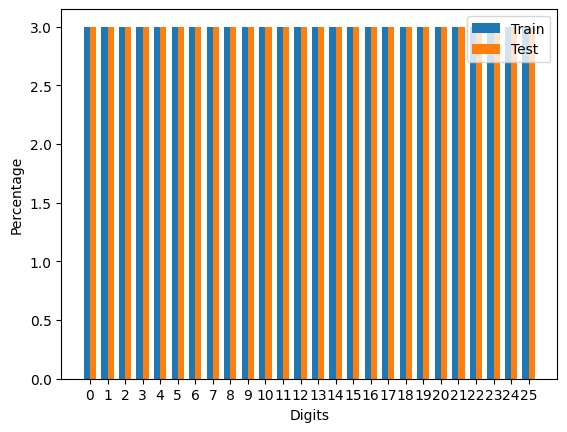

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = set(emnist_train.targets.cpu().numpy())

x = np.arange(26)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [int(sum(emnist_train.targets.cpu().numpy() == i) / len(emnist_train.targets) * 100) for i in classes], width, label='Train')
rects2 = ax.bar(x + width/2, [int(sum(emnist_test.targets.cpu().numpy() == i) / len(emnist_test.targets) * 100) for i in classes], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_xlabel('Digits')

ax.legend()
plt.xticks([i for i in classes])
plt.show()

We print the first 500 images contained in the training set. From that we can notice that some letters are rotated

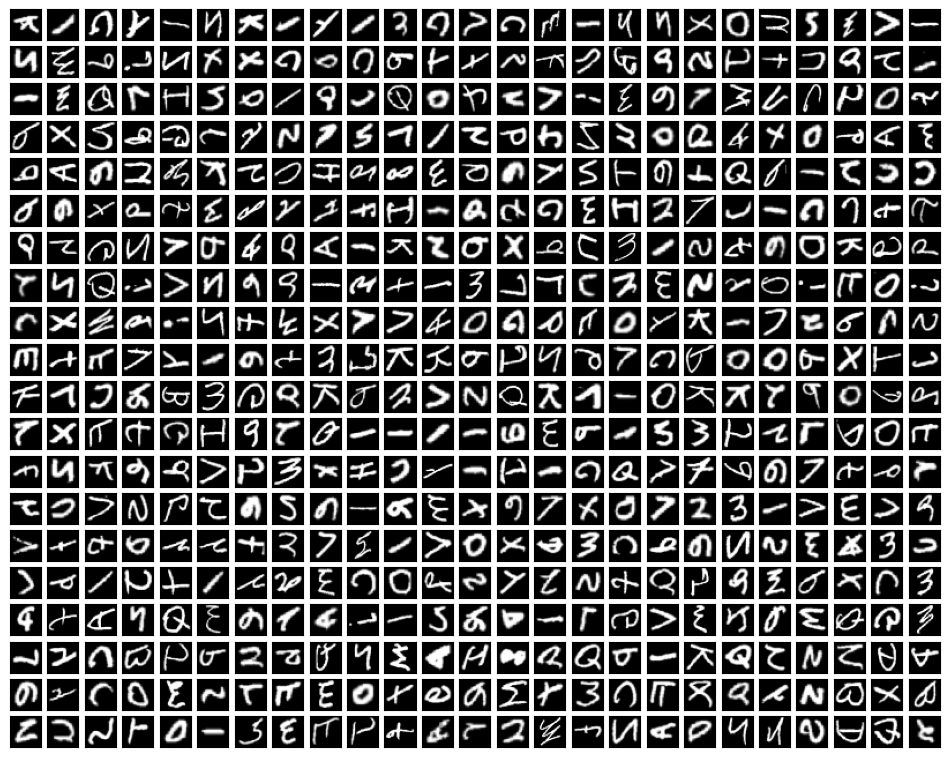

In [ ]:
indices = torch.randint(0, len(emnist_train.data), (500,))
images = [emnist_train.data[i] for i in indices]

# Plot the images in a grid
fig = plt.figure(figsize=(12, 12))
for i in range(500):
    ax = fig.add_subplot(25, 25, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i].to('cpu'), cmap='gray')

plt.show()

# DBN

We start training the Deep Belief Network (DBN). A Deep Belief Network is an unsupervised learning algorithm. It's made up by multiple layers of Restricted Boltzmann Machines (RBM). Each RBM consists of a visible unit level and a hidden unit level, and is trained separately using an algorithm called Contrastive Divergence; the output of the hidden units of the first RBM is used as input to train the second RBM, and so on until the last layer is reached. Once all RBM are trained, the DBN can be trained using supervised learning to optimize connections between layers.

We set the number of visible units in the DBN to 28x28, which corresponds to the size of the input images. Then, we specify the number of hidden units in each layer of the DBN. In our case, the DBN is configured with three hidden layers, and the number of hidden units in each layer is set to 400, 500, and 800, respectively. To train the DNB we use the contrastive divergence algorithm, setting the number of contrastive divergence steps to 1.

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[400, 500, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

The DBN is trained through 50 epochs using a batch size equal to 125.

In [ ]:
num_epochs = 50
batch_size = 125

dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3466     |0.0453       |337.8442   |5.5056     |
|20    |1.2868     |0.0414       |320.2952   |5.0413     |
|30    |1.2764     |0.0415       |315.5432   |5.2278     |
|40    |1.2720     |0.0403       |313.6354   |4.9918     |
|50    |1.2687     |0.0401       |312.1414   |4.4849     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.5624     |0.0430       |220.8254   |3.1537     |
|20    |1.5151     |0.0392       |215.8156   |2.7179     |
|30    |1.5018     |0.0405       |214.4546   |2.6159     |
|40    |1.4976     |0.0394       |213.6567   |2.9409     |
|50    |1.4938     |0.0377       |213.0888   |2.6775     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1039     |0.0315       |255.3565   |3.6501     |
|20    |1.0356     |0.0284       |243.8034   |3.400

We want that our average reconstruction error decreases in all the three layers; this is confirmed by the results. This indicates better reconstruction performance because the application of the gradient descent works.

# Receptive fields

We now visualize the learned weights of the DNB. The aim to plot the weights is to detecte wich parts of the images trigger a particular neuron or group of them in a layer.
To do that, we apply the MinMaxScaler to normalize the values of different weights.

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

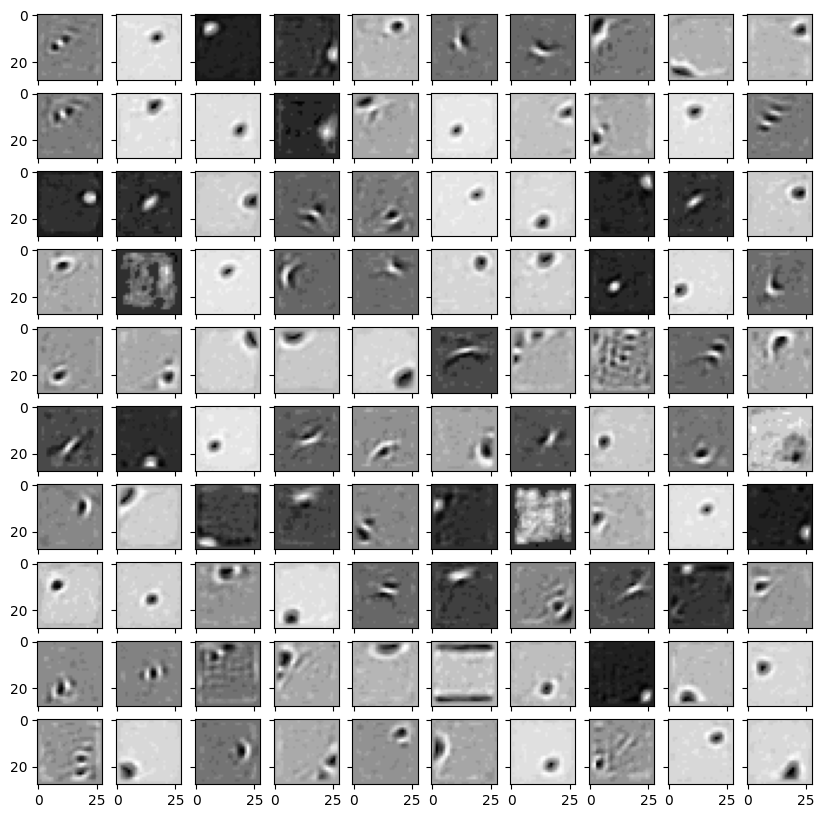

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

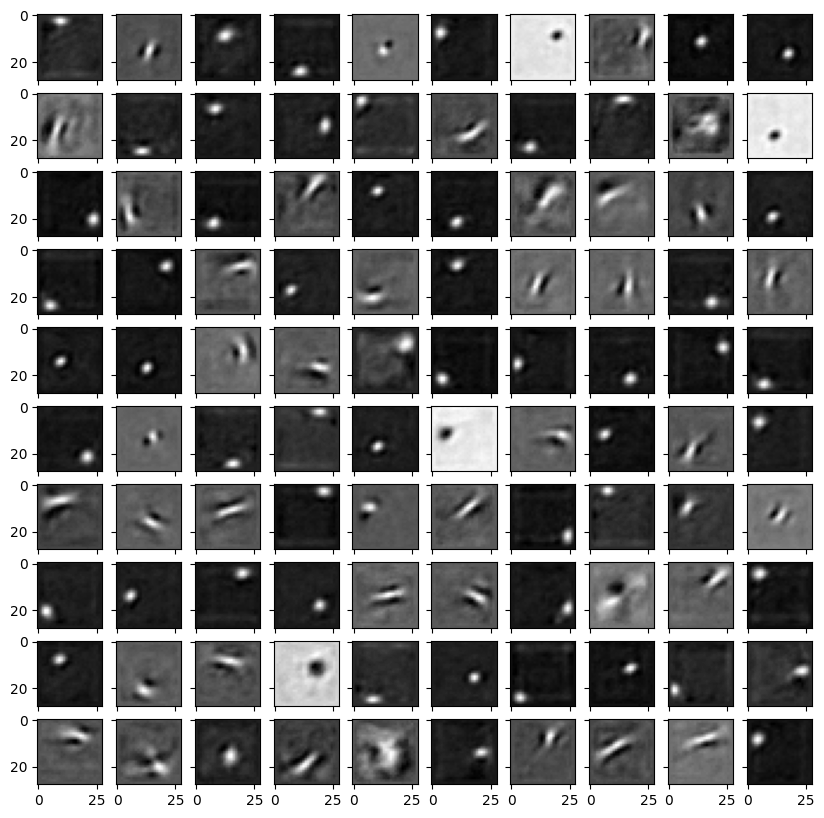

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

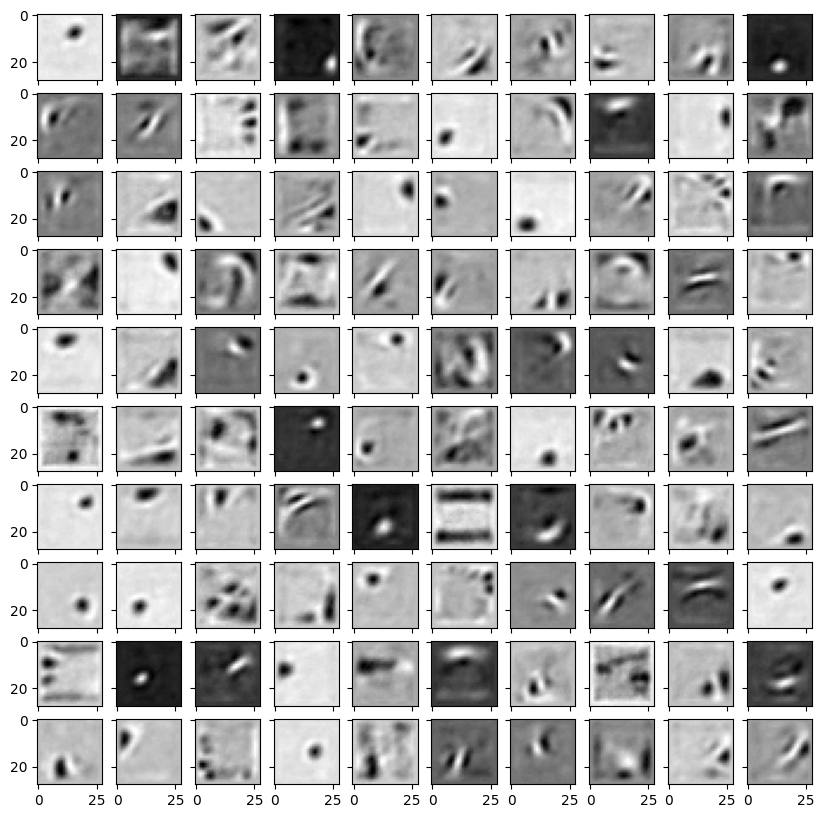

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

The results show how moving forward with the layers, th receptive fields become more complex. This can be explained knowing that the deeper layers capture more specific patterns, compared to the initial layers that work on the more general particulars.

# Clustering internal representation

We build a dendogram to see how much similar are the letters for the DBN. In order to do that, we use clustering analysis.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [ ]:
def get_mask(label):  # we use this function to filter by class
  labels = emnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(26)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(26)])

In [ ]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

In [ ]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

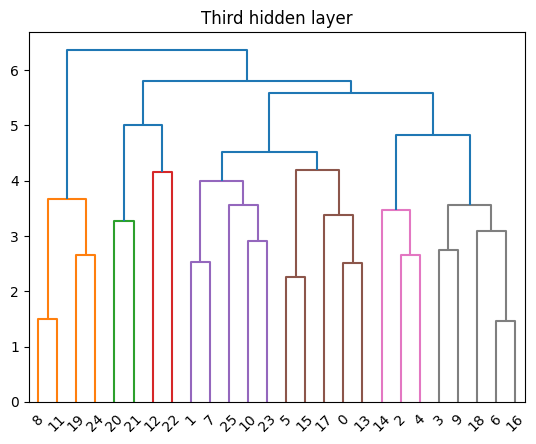

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

The dendogram shows how much the letters ar similar: "I" and "L" are similiar and also "G" and "Q". The first similarity is pretty logical because because in handwriting these two letters even a human eye can get confused.

# Linear read out

We want to apply a linear model to decode the hidden representation of the data computed by the DNB. By doing this we pass from an unsupervised approach to a supervised one.

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 26)

  def forward(self, x):
    return self.linear(x)

The following cell instead initialize the three read-out.


In [ ]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [ ]:
def train(network, input, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch, epochs, loss))

In [ ]:
train(linear1, hidden_repr_layer_1)

epoch :   0/1500, loss = 3.2949
epoch : 100/1500, loss = 2.2120
epoch : 200/1500, loss = 1.7469
epoch : 300/1500, loss = 1.5161
epoch : 400/1500, loss = 1.3807
epoch : 500/1500, loss = 1.2905
epoch : 600/1500, loss = 1.2248
epoch : 700/1500, loss = 1.1740
epoch : 800/1500, loss = 1.1329
epoch : 900/1500, loss = 1.0987
epoch : 1000/1500, loss = 1.0694
epoch : 1100/1500, loss = 1.0440
epoch : 1200/1500, loss = 1.0216
epoch : 1300/1500, loss = 1.0016
epoch : 1400/1500, loss = 0.9836


In [ ]:
train(linear2, hidden_repr_layer_2)

epoch :   0/1500, loss = 3.2809
epoch : 100/1500, loss = 2.1493
epoch : 200/1500, loss = 1.7031
epoch : 300/1500, loss = 1.4901
epoch : 400/1500, loss = 1.3660
epoch : 500/1500, loss = 1.2828
epoch : 600/1500, loss = 1.2218
epoch : 700/1500, loss = 1.1742
epoch : 800/1500, loss = 1.1355
epoch : 900/1500, loss = 1.1030
epoch : 1000/1500, loss = 1.0752
epoch : 1100/1500, loss = 1.0510
epoch : 1200/1500, loss = 1.0296
epoch : 1300/1500, loss = 1.0104
epoch : 1400/1500, loss = 0.9930


In [ ]:
train(linear3, hidden_repr_layer_3)

epoch :   0/1500, loss = 3.2591
epoch : 100/1500, loss = 2.1403
epoch : 200/1500, loss = 1.6694
epoch : 300/1500, loss = 1.4402
epoch : 400/1500, loss = 1.3064
epoch : 500/1500, loss = 1.2169
epoch : 600/1500, loss = 1.1513
epoch : 700/1500, loss = 1.1004
epoch : 800/1500, loss = 1.0591
epoch : 900/1500, loss = 1.0245
epoch : 1000/1500, loss = 0.9949
epoch : 1100/1500, loss = 0.9692
epoch : 1200/1500, loss = 0.9464
epoch : 1300/1500, loss = 0.9261
epoch : 1400/1500, loss = 0.9078


For each linear model, we notice that the loss decreases.

In [ ]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [ ]:
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

We compute predictions to compare the accuracy values computed on the test set for the three different layers of the DNB.

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
print(compute_accuracy(predictions_test1, emnist_test.targets))
print(compute_accuracy(predictions_test2, emnist_test.targets))
print(compute_accuracy(predictions_test3, emnist_test.targets))

0.7318750023841858
0.7288942337036133
0.755432665348053


The deeper the layer becomes, the higher the accuracy goes.

# Feed-forward model

We define a Feed-forward model to compare its results with the ones of the DNB. Unlike DNB, the Feed-forward is a supervised model, in which information goes sequentially from input to output and adjusts its weights through backpropagation.

To compare this model with the DNB, we define the Feed-forward structure the same as that of the unsupervised model. We use the "ReLu" as activation function.

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 26)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
ffnn = Feedforward(400, 500, 800).to(device)

In [ ]:
train(ffnn, emnist_train.data.reshape((124800, 784)))

epoch :   0/1500, loss = 3.2586
epoch : 100/1500, loss = 3.2309
epoch : 200/1500, loss = 3.1220
epoch : 300/1500, loss = 2.5149
epoch : 400/1500, loss = 1.8026
epoch : 500/1500, loss = 1.4961
epoch : 600/1500, loss = 1.3384
epoch : 700/1500, loss = 1.2348
epoch : 800/1500, loss = 1.1579
epoch : 900/1500, loss = 1.1014
epoch : 1000/1500, loss = 1.0341
epoch : 1100/1500, loss = 0.9778
epoch : 1200/1500, loss = 0.9235
epoch : 1300/1500, loss = 0.8728
epoch : 1400/1500, loss = 0.8257


In [ ]:
predictions_ffnn = ffnn(emnist_test.data.reshape((20800, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, emnist_test.targets)

0.7702403664588928

The accuracy obtained with the Feed-forward model is 77.02%, larger by about 1.5% than the one produced by the deepest DNB read out (75.54%). The feed-forward model performs slightly better than the DNB read out in terms of accuracy

# Robustness to the noise

We want to observe the prediction capabilities of the two previously defined models in a situation where we add noise to the figures in the test set.

Will our models still turn out to be robust?

In [ ]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor

We set different levels of noise; in the images below we notice that increasing the noise parameter makes images less recognizable.

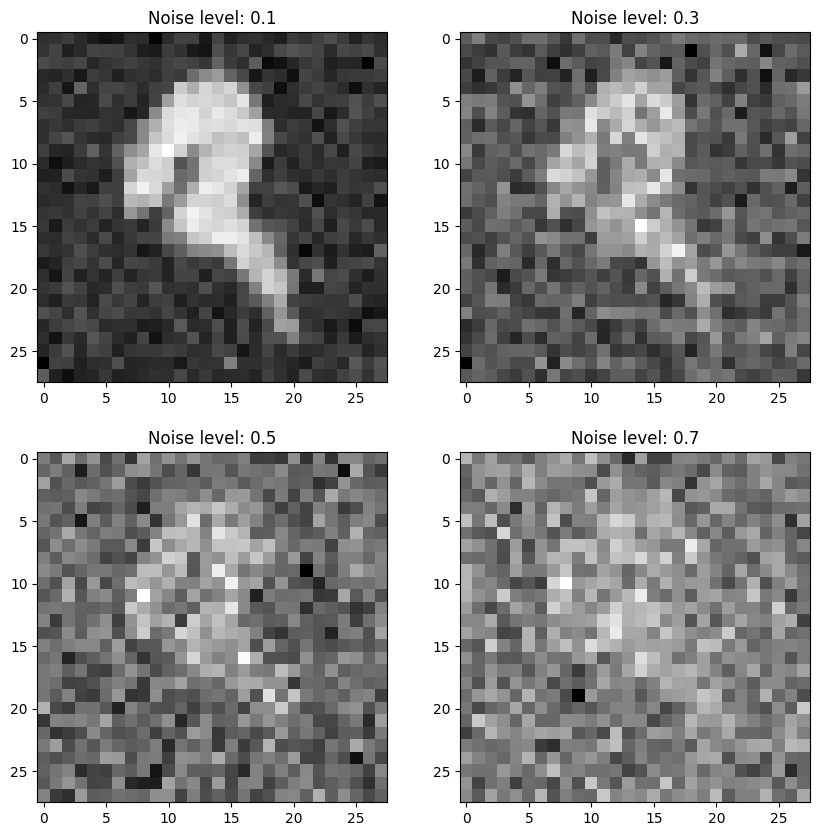

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

noise_level_list = [0.1, 0.3, 0.5, 0.7]
for idx, noise_level in enumerate(noise_level_list):
    row = idx // 2
    col = idx % 2
    emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
    axs[row, col].imshow(emnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")
    axs[row, col].set_title(f"Noise level: {noise_level}")

plt.show()


In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  mnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images

  hidden_repr_layer_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)

  predictions_ffnn_noisy = ffnn(mnist_test_with_noise.reshape((20800, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.697
Accuracy of H2 read-out: 0.712
Accuracy of H3 read-out: 0.743
Accuracy of FF network : 0.724


From the accuracy results we see that in DNB read out, the noise has an higher impact on the first and the layer, but the accuracy related to the third layer is slightly lower than the one computed on the images without noise. On the opposite, the Feed-forward model has an higher reduction of the accuracy value of approximately 5%. DNB read out results more robust to the noise in respect with the Feed-forward model.

We can also compute the psychometric curves, that suggest us how the accuracy change with the noise increasing.

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

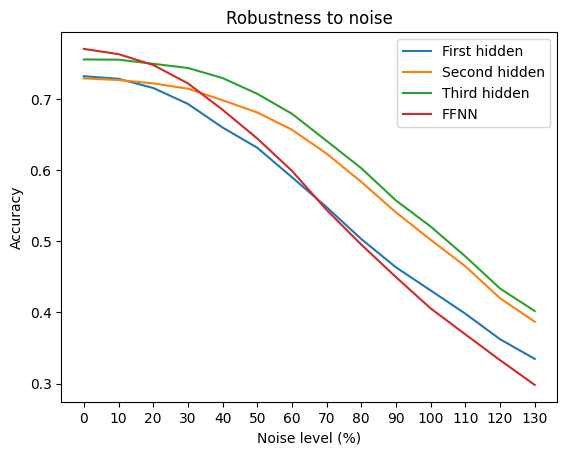

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

The curves confirm the results previously described.

We can check the classification performances of the models on noise data also with another tool: the confusion matrix; it shows on the diagonal the right predictions made by the model, while the off-diagonal elements are the missclassifed predictions.

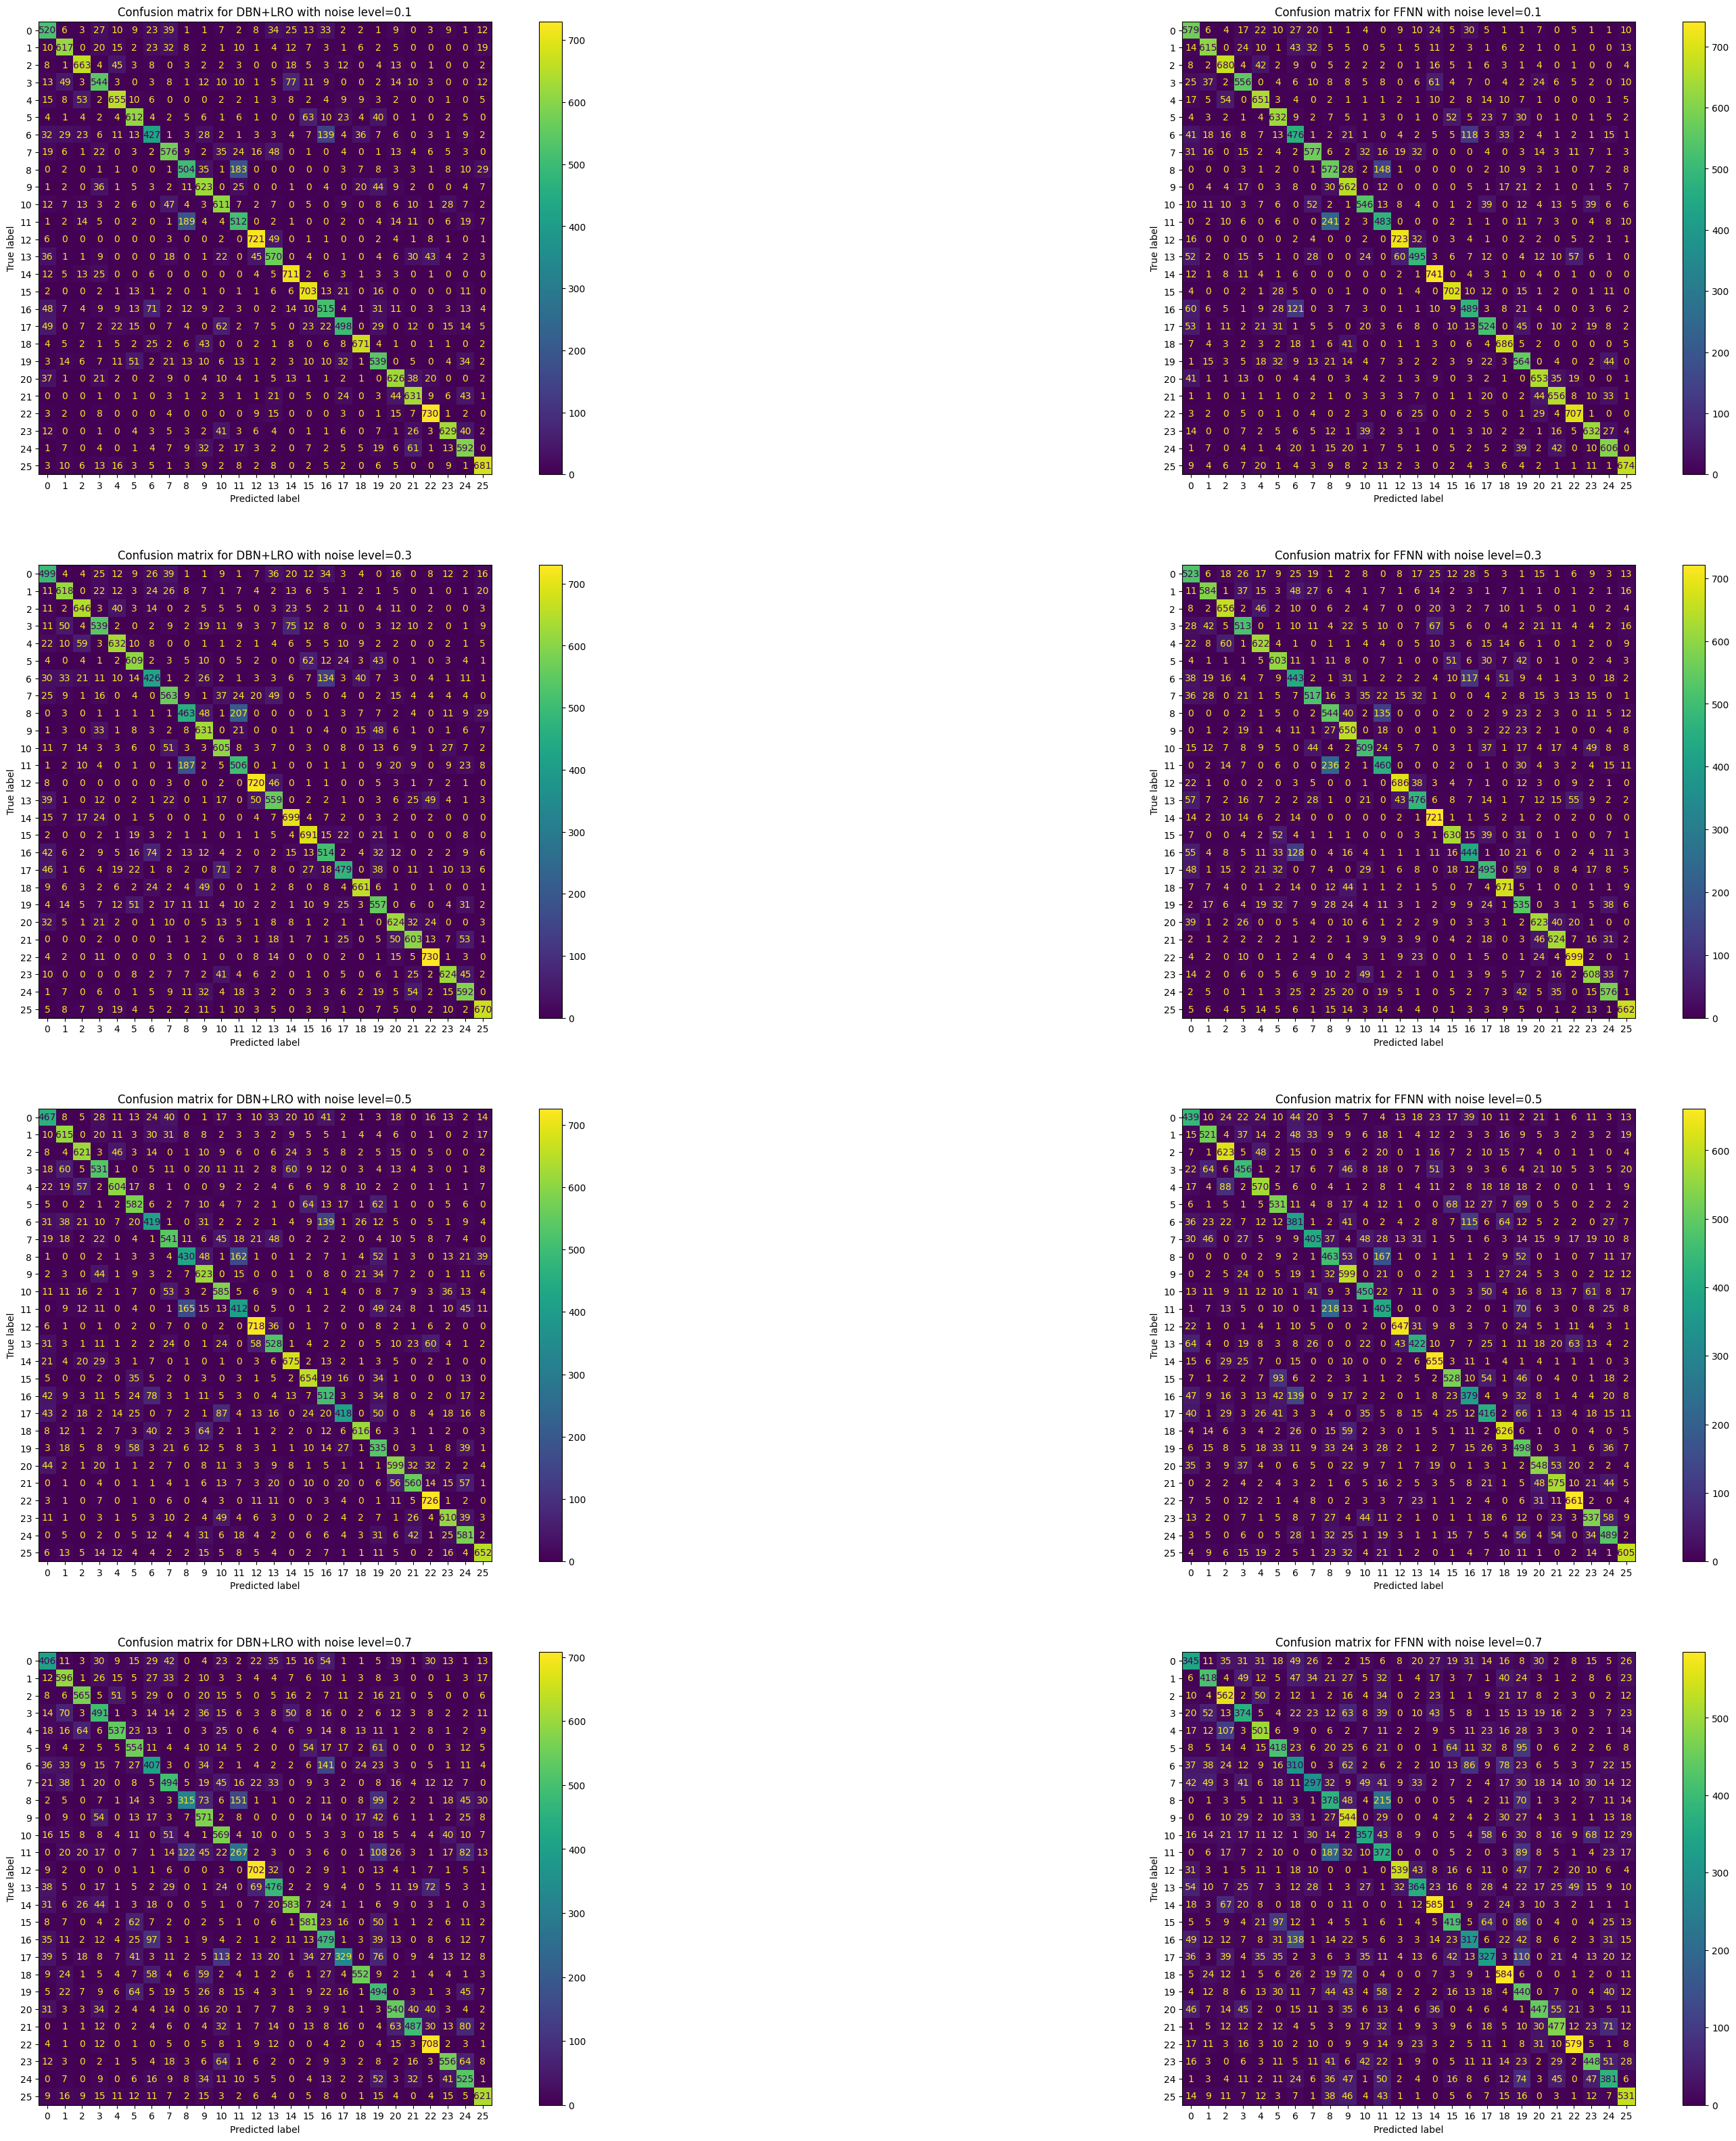

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json



noise_level1 = 0.1
noise_level2 = 0.3
noise_level3 = 0.5
noise_level4 = 0.7


#dbn+lro
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level1)  # first, let's create noisy test images

hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

predictions_indices = predictions_third_hidden_noisy.max(axis=1).indices

cm1 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())

# ffnn
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level1)  # first, let's create noisy test images

predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))

predictions_indices = predictions_ffnn_noisy.max(axis=1).indices

cm2 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())

#dbn+lro 2
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level2)  # first, let's create noisy test images

hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

predictions_indices = predictions_third_hidden_noisy.max(axis=1).indices

cm3 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())

# ffnn 2
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level2)  # first, let's create noisy test images

predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))

predictions_indices = predictions_ffnn_noisy.max(axis=1).indices

cm4 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())

#dbn+lro 3
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level3)  # first, let's create noisy test images

hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

predictions_indices = predictions_third_hidden_noisy.max(axis=1).indices

cm5 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())

# ffnn 3
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level3)  # first, let's create noisy test images

predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))

predictions_indices = predictions_ffnn_noisy.max(axis=1).indices

cm6 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())

#dbn+lro 4
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level4)  # first, let's create noisy test images

hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

predictions_indices = predictions_third_hidden_noisy.max(axis=1).indices

cm7 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())

# ffnn 4
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level4)  # first, let's create noisy test images

predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))

predictions_indices = predictions_ffnn_noisy.max(axis=1).indices

cm8 = confusion_matrix(emnist_test.targets.to('cpu').detach().numpy(), predictions_indices.to('cpu').detach().numpy())

fig, axs = plt.subplots(4, 2, figsize=(40, 40))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=list(range(26)))
disp1.plot(ax=axs[0,0])
axs[0,0].set_title('Confusion matrix for DBN+LRO with noise level=0.1')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=list(range(26)))
disp2.plot(ax=axs[0,1])
axs[0,1].set_title('Confusion matrix for FFNN with noise level=0.1')

disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=list(range(26)))
disp3.plot(ax=axs[1,0])
axs[1,0].set_title('Confusion matrix for DBN+LRO with noise level=0.3')

disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=list(range(26)))
disp4.plot(ax=axs[1,1])
axs[1,1].set_title('Confusion matrix for FFNN with noise level=0.3')

disp5 = ConfusionMatrixDisplay(confusion_matrix=cm5, display_labels=list(range(26)))
disp5.plot(ax=axs[2,0])
axs[2,0].set_title('Confusion matrix for DBN+LRO with noise level=0.5')

disp6 = ConfusionMatrixDisplay(confusion_matrix=cm6, display_labels=list(range(26)))
disp6.plot(ax=axs[2,1])
axs[2,1].set_title('Confusion matrix for FFNN with noise level=0.5')

disp7 = ConfusionMatrixDisplay(confusion_matrix=cm7, display_labels=list(range(26)))
disp7.plot(ax=axs[3,0])
axs[3,0].set_title('Confusion matrix for DBN+LRO with noise level=0.7')

disp8 = ConfusionMatrixDisplay(confusion_matrix=cm8, display_labels=list(range(26)))
disp8.plot(ax=axs[3,1])
axs[3,1].set_title('Confusion matrix for FFNN with noise level=0.7')

plt.show()

According to the previous results, the confusion matrices show that the increase of the noise levels corresponds to poorer performances of the models. Looking at the main diagonals, we confirm that the DNB read out model seems to be more robust to the noise injection.

# Perturbing the models with adversarial attack

We apply adversarial attack: it is a technique in which we modify the input in order to confuse a model during the classification phase. Since the model does not recognize the input, the loss function tends to grow.

To avoid the growth of the loss, in the gradient descent we move in the same direction of the gradient. Moreover, we don't change the weights anymore, but we change the input.

## Fast gradient sign method

We control the strenght of the attack setting a parameter epsilon.

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

## Adversarial samples

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

The chosen sample is 3.


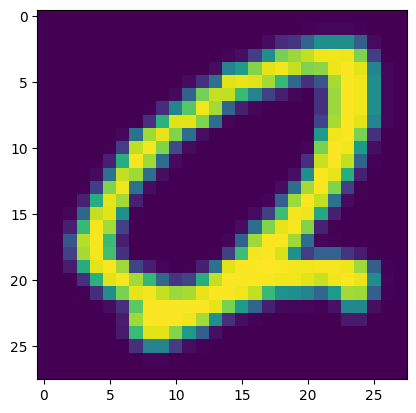

In [ ]:
test_sample_idx = 3
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))
print(f"The chosen sample is {test_sample_idx}.")

We pick one sample to classify it using the models that we have previously implemented.

We start with the Feed-forward model.

In [ ]:
attacked_model = ffnn

In [ ]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 16.


The model classify the prediction as a "Q"; it seems to be reasonable.

We generate the adversarial sample related to the one chosen before.

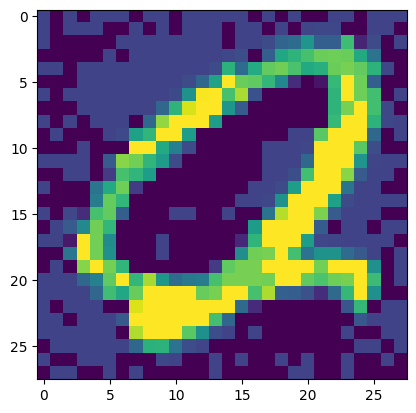

In [ ]:
epsilon = 0.2  # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 20.


The adversarial sample deceives the model because the latter misclassifies the prediction.

So, we pass to the DNB read out.

In [ ]:
attacked_model = dbn_with_readout

In [ ]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 16.


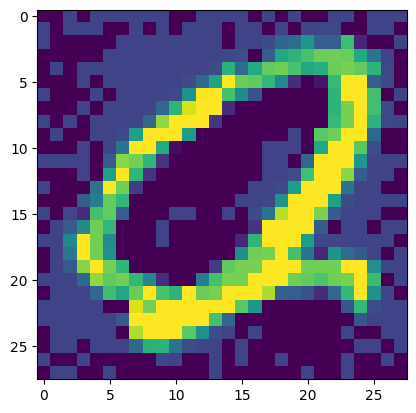

In [ ]:
epsilon = 0.2  # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 16.


As we can see, DNB read out classify correctly the letter, recognizing the "Q".

## Resisting to adversarial attacks

Now we want to compare the ability of the two models to resist to adversarial attacks. Moreover, we introduce the `num_steps` parameter, that controls the reconstruction of the image perturbed by the attack.



In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
emnist_test_1 = tv.datasets.EMNIST('data/',
                                    split='letters',
                                    train =False,
                                    download=False,
                                    transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()])
                                      )


In [ ]:
emnist_test_1.targets -= 1

test_loader = torch.utils.data.DataLoader(
    emnist_test_1,
    batch_size=100, shuffle=True)

In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 23.72%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 53.98%



  0%|          | 0/208 [00:00<?, ?it/s]


Here's the original sample:



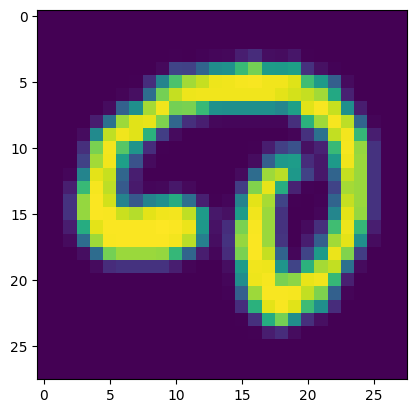


Here's a perturbed sample:



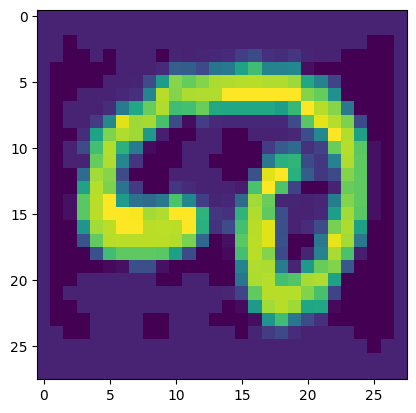


Here's what a 1-steps reconstructed sample looks like:



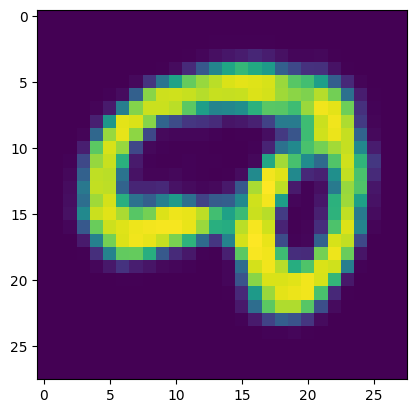


Epsilon: 0.1
Test Accuracy: 58.89%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

As we've seen before the Feed-forward model works bad when the input is perturbated by the adversarial attack. Using the DBN read out we obtain a clear improvment. Finally, we notice that applying the reconstruction parameter to the DBN read out model, we further improve the accuracy value.

## Effect of the noise parameter $\epsilon$

Now, we compare the robustness of each model to adversarial attacks of different "strengths".

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

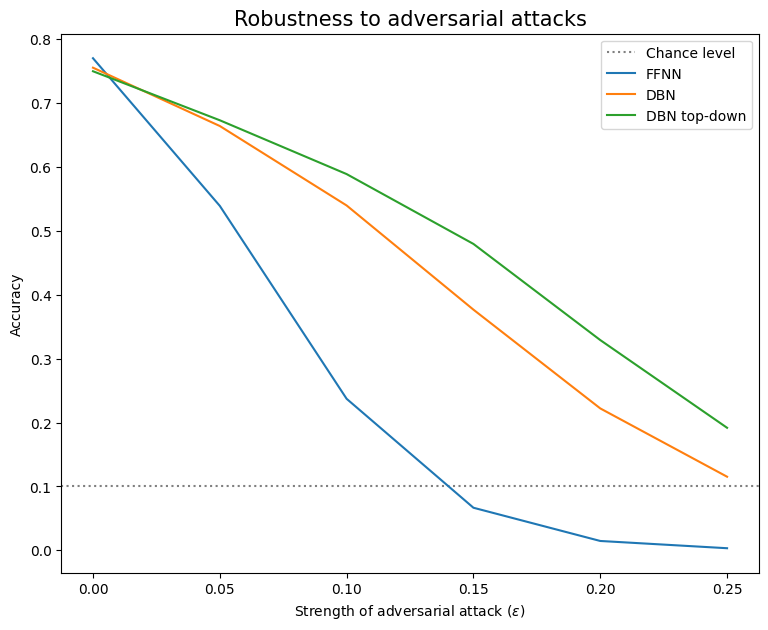

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

The graph shows how the accuracy decreases when the strength of the adversarial attack increases. It confirms the considerations made previously: the DNB read out with the reconstruction parameter is the one with the best resilience to the adversarial attack, but also the DNB read out has much better results than the Feed-forward model.

# Recap

Firstly, we trained a Deep Belief Network over the dataset EMNIST to analyze the images contained in it; to help us, we exploited the cluster analysis and the receptive fields related to the weights of the network.

We also implemented a Linear read out on the DBN model, to decode its hidden representation of the data.

After that, we trained a Feed-forward model; we compare its accuracy result with the one obtained with the DBN + Linear read out and we concluded that the results were very similar.

Our analysis continued injecting some noise to the images to see how our models perform: the results were that the DNB + Linear read out is more robust than the Feed-forward model when we perturb our data with some noise; that was confirmed by the confusion matrices.

We did a similar test, applying the adversarial attack, in order to pursue the same purpose of the injection of noise. Also in this case the DBN + Linear read out performed better than the Feed forward model.

So, in cocnlusion, we can say that the Deep Belief Network performs better on the data compared to the Feed-Forward model.